<a href="https://colab.research.google.com/github/achanbour/ccmi-cdt-data-driven-modelling/blob/main/1_ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Simulation-Based Models to Data - Lotka Volterra Example

## Deterministic Lotka Volterra

In this first notebook, we will explore how to fit a model to data using Approximate Bayesian Computation (ABC). We will use the Lotka Volterra equations as an instructive biological problem.

The classical Lotka Volterra equations represents the population of prey, $x$, and predators, $y$, as continuous variables which change deterministically according to the equations:
$$\frac{dx}{dt}=\alpha x - \beta x y$$
$$\frac{dy}{dt}=\delta x y - \gamma y$$

First, let's import the modules we'll use throughout. Let's install the non-bundled packages:

In [ ]:
try:
    import corner
    import pyabc
    import seaborn as sns

except ModuleNotFoundError:
    %pip install pyabc corner seaborn
    import corner
    import pyabc
    import seaborn as sns

In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import os
import tempfile
import sys

Now, let's code up the classic Lotka Volterra ODEs to evaulate the system at timepoints $t$ with parameters $\{\alpha, \beta, \delta, \gamma \}$ and initial conditions $(X_0, Y_0)$

In [ ]:
def LotkaVolterraODE(t, x_y, alpha, beta, delta, gamma):
    """
    Calculate d([x, y])/dt for the Lotka Volterra system.

    Parameters
    ----------
    t : float
        Time (required by odeint function).
    x_y : [float, float]
        Populations array (prey, predator).
    alpha : float
        Prey growth rate.
    beta : float
        Prey death rate per predator.
    delta : float
        Predator growth rate per prey.
    gamma : float
        Predator death rate.


    Returns
    -------
    [float, float]
        The instantaneous rate of change of the prey and
        predator populations.
    """
    x, y = x_y

    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y

    return np.array([dx_dt, dy_dt])

def LotkaVolterraDeterministic(
        params,
        InitialConditions,
        t
    ):
    """
    Integrate the Lotka Volterra system given a set of
    parameters and initial conditions at times t.

    Parameters
    ----------
    params : np.array([alpha, beta, delta, gamma])
        The prey growth rate, prey death rate per
        predator, predator growth rate per prey and
        predator death rate.
    InitialConditions : [float, float]
        Populations array (prey, predator) at time t[0].
    t : np.array([float, float, ...])
        Times at which to evaluate system.

    Returns
    -------
    np.array([float, float, ...])
        The prey and predators populations evaluated at
        times t.
    """

    tspan = (np.min(t), np.max(t))

    out = solve_ivp(LotkaVolterraODE, tspan,
                InitialConditions, t_eval=t,
                args=params,
                method='RK45', rtol=10**-6)

    out['y'][out['y'] < 0.0] = 0.0

    return out['y']

Before we start trying to fit our model to data, let's play around with different combinations of parameters. Below, you can change the rate parameters $\{\alpha, \beta, \delta, \gamma \}$ and the initial conditions $(X_0, Y_0)$ and see how the populations over time change. Also, plotting the data in "phase space" can be a helpful way to understand the dynamics of the system.

Things to consider:
- How does the periodicity of the oscillations change with the parameters?
- Can you find a combination of parameters where the populations stay fixed (i.e. the steady state solution)?
- How does changing the initial conditions alter the orbits of the system in phase space?

(0.0, 130.89693484726507)

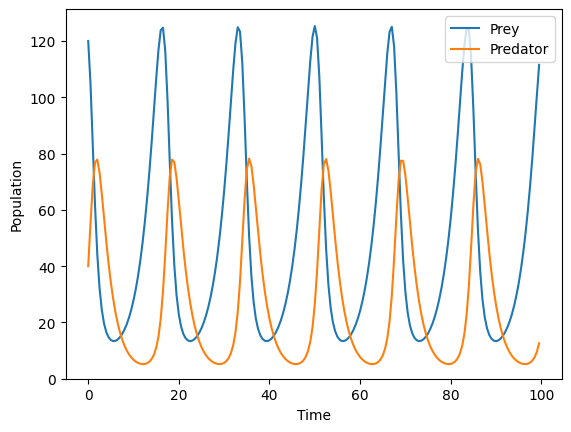

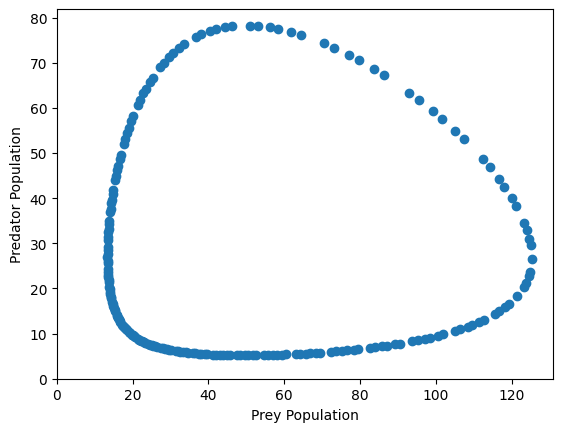

In [ ]:
alpha = 0.35
beta = 1.3 * 10**-2
delta = 1 * 10**-2
gamma = 0.5

t = np.arange(0, 100, 0.5)

InitialConditions = np.array([120, 40])

PreyPred = LotkaVolterraDeterministic(
        [alpha, beta, delta, gamma],
        InitialConditions,
        t
    )

fig, ax = plt.subplots()
a = plt.plot(t, PreyPred[0, :])
b = plt.plot(t, PreyPred[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
a = plt.scatter(PreyPred[0, :], PreyPred[1, :])
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

To fit our model to data, we first need some sort of error model, to account for the random measurement error. For simplicity, let's assume that the errors are Poissonian (counting statistics).

In [ ]:
def LotkaVolterraDeterministicError(
        params,
        InitialConditions,
        t,
        rng=None
    ):
    """
    Function to integrate the Lotka Volterra ODE and
    add Poisson distributed noise on top.

    Parameters
    ----------
    params : np.array([alpha, beta, delta, gamma])
        The prey growth rate, prey death rate per
        predator, predator growth rate per prey and
        predator death rate.
    InitialConditions : [float, float]
        Populations array (prey, predator) at time t[0].
    t : np.array([float, float, ...])
        Times at which to evaluate system.
    rng : np.random.default_rng()
        Numpy random generator

    Returns
    -------
    np.array([float, float, ...])
        The noisy prey and predators populations
        evaluated at times t.
    """
    if rng is None:
        rng = np.random.default_rng()

    xy = LotkaVolterraDeterministic(params, InitialConditions, t)

    return rng.poisson(xy)

(0.0, 153.25)

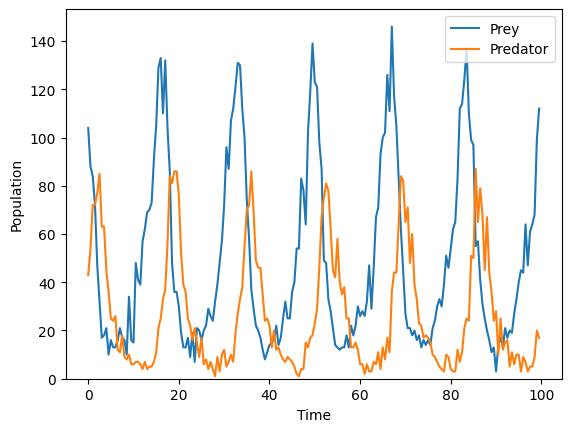

In [ ]:
rng = np.random.default_rng()

PreyPredErr = LotkaVolterraDeterministicError([alpha, beta, delta, gamma],
                                         InitialConditions, t, rng)

fig, ax = plt.subplots()
a = plt.plot(t, PreyPredErr[0, :])
b = plt.plot(t, PreyPredErr[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

Note that for the classical Lotka Volterra system we could write down a likelihood function and use likelihood based methods (MCMC, MLE, etc.), but we're going to use Approximate Bayesian Computation (ABC) to give an instructive example.

For ABC, we need to define a model that we can use to generate simulated data and a distance metric that we can use to compare the simulated data the the experimental data. In the interests of simplicity, let's assume that we know that $\beta = \delta$, so we only need to infer $\alpha$, $\beta$ and $\gamma$.

There are many possible distance functions one could use, but here we've chosen a normalised Euclidean distance between the simulated and observed time series, scaling by both the number of time points and the mean population size. This makes the distance approximately dimensionless and comparable across parameter values. Can you think of other possible distance metrics that may be more optimal?

In [ ]:
def model(parameters, constants):
    """
    Wrapper function to simulate the deterministic Lotka
    Volterra system in the syntax pyabc expects (e.g.
    with the parameters parcelled into a dictionary and
    the output returned as a dictionary).

    Parameters
    ----------
    parameters : dict
        Dictionary containing:
            "alpha" : the prey growth rate,
            "beta" : prey death rate per predator
            "gamma" : predator death rate.
    constants : [float, np.array(float, float, ...),
                        np.random.default_rng()]
        List containing the populations array
        (prey, predator) at time t[0], the times
        at which to evaluate system and a Numpy
        random generator.

    Returns
    -------
    dict()
        Dictionary containing the noisy prey and predators
        populations evaluated at times t.
    """
    alpha = parameters["alpha"]
    gamma = parameters["gamma"]
    beta = parameters["beta"]
    delta = beta

    InitialConditions, t, rng = constants

    PreyPredErr = LotkaVolterraDeterministicError([alpha, beta, delta, gamma],
                                         InitialConditions, t, rng)
    return {"data": PreyPredErr}

def distance(x, x0):
    return np.linalg.norm(x["data"] - x0["data"]) / (np.shape(x0["data"])[1] * np.mean(x0["data"]))

Fitting our model to 200 datapoints may take awhile, so in the interests of time, we'll limit ourselves to 11 timepoints over 25 years.

(0.0, 122.4)

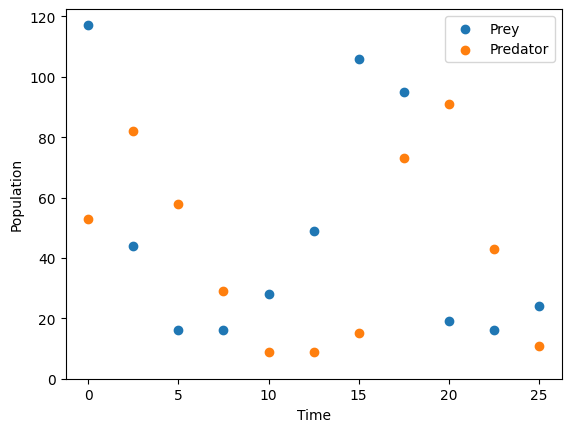

In [ ]:
t_eval = np.linspace(0, 25, 11)
rng = np.random.default_rng()
InitialConditions = np.array([120, 40])

constants = [InitialConditions, t_eval, rng]

alphaTrue = 0.35
gammaTrue = 0.5
betaTrue = 10**-2

dataDeterminism = model({"alpha":alphaTrue, "gamma":gammaTrue,
                         "beta":betaTrue}, constants)

fig, ax = plt.subplots()
a = plt.scatter(t_eval, dataDeterminism["data"][0, :])
b = plt.scatter(t_eval, dataDeterminism["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

We need to define a prior to put on $\alpha$, $\beta$ and $\gamma$. All these parameters are strictly positive and continuous, so let's use a lognormal distribution. For the purposes of the exercise, I'm going to assume that we have some prior knowledge suggesting $\alpha,\gamma \approx 1$ and $\beta \approx 10^{-2}$. In practice, the choice of priors requires a level of domain-specific knowledge (e.g. wider literature, biological limitations etc.), but for a well-formed model, the effect of the prior on the posterior should decrease as we get more data.

It's often easier to define a prior on the scale of the parameter you're interested in, so let's write a function to convert the mean and standard deviation of the priors to the parameters that scipy accepts (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

In [ ]:
def lognormal_convert_params(mu, sigma):
    """
    Convert mean/dispersion parameterization of a beta
    distribution to the ones scipy supports, (log_mu,
    log_sigma). To use the output of this function with
    the scipy lognormal rng distribution, do
    scipy.stats.lognorm(loc=log_std,
                        scale=np.exp(log_mean),
                        **kwargs)

    Parameters
    ----------
        mu : float
            Mean of the lognormal distribution on the
            real scale
        sigma :
            Standard deviation of lognormal distribution
            on the real scale

    Returns
    -------
    [float, float]
            The mean and standard deviation of the lognormal
            distribution on the log scale.
    """
    if np.any(mu <= 0):
        raise Exception("mu must be greater than 0")
    elif np.any(sigma <= 0) :
        raise Exception("sigma must be greater than 0")

    log_mean = np.log(mu) - 0.5 * np.log1p(sigma**2 / mu**2)
    log_std = np.sqrt(np.log1p(sigma**2 / mu ** 2))

    return (log_mean, log_std)

log_mean_alpha, log_std_alpha = lognormal_convert_params(1, 1)
log_mean_gamma, log_std_gamma = lognormal_convert_params(1, 1)
log_mean_beta, log_std_beta = lognormal_convert_params(10**-2, 10**-2)

# --- Prior sampler used by rejection ABC ---
def sample_from_prior_lognormal(rng):
    """
    Draw one parameter set from the user's lognormal priors.
    Uses scipy.stats.lognorm with a provided numpy Generator.
    """
    alpha = stats.lognorm.rvs(s=log_std_alpha, scale=np.exp(log_mean_alpha), random_state=rng)
    gamma = stats.lognorm.rvs(s=log_std_gamma, scale=np.exp(log_mean_gamma), random_state=rng)
    beta  = stats.lognorm.rvs(s=log_std_beta,  scale=np.exp(log_mean_beta),  random_state=rng)
    return {"alpha": float(alpha), "gamma": float(gamma), "beta": float(beta)}

What do those prior distributions look like? It's important to consider not only the mean of your prior, but also how much probability mass you're putting at very low and very high values (e.g. the degree of uncertainty)

Text(0, 0.5, 'Probability density')

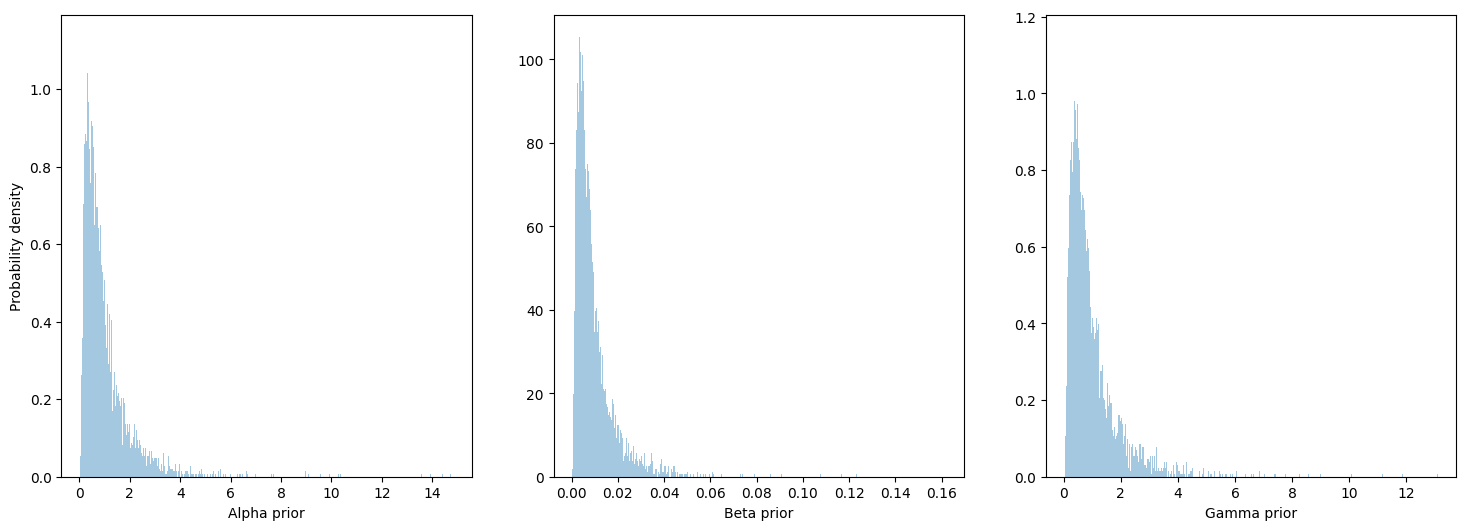

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
a = axes[0].hist(stats.lognorm(log_std_alpha,
                               scale=np.exp(log_mean_alpha)).rvs(10000),
            1000, alpha = 0.4, density = True)
axes[0].set_xlabel("Alpha prior")
b = axes[1].hist(stats.lognorm(log_std_beta,
                               scale=np.exp(log_mean_beta)).rvs(10000),
            1000, alpha = 0.4, density = True)
axes[1].set_xlabel("Beta prior")
c = axes[2].hist(stats.lognorm(log_std_gamma,
                               scale=np.exp(log_mean_gamma)).rvs(10000),
            1000, alpha = 0.4, density = True)
axes[2].set_xlabel("Gamma prior")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False,
                left=False, right=False)
plt.ylabel("Probability density")

Excellent, first let's implement our own version of rejection ABC from scratch. The idea here is to sample from our prior many times, for each draw calculate the distance compared to the target data, and only keep the draws with a distance below some threshold epsilon.

In [ ]:
def rejection_abc(model, distance, x0, constants, rng,
                  epsilon, n_accept=200, max_tries=200_000,
                  verbose=True):
    """
    Very simple rejection ABC.

    Parameters
    ----------
    epsilon : float
        Accept parameters if distance(sim, x0) <= epsilon.
    n_accept : int
        Number of accepted particles to collect.
    max_tries : int
        Safety cap so we don't loop forever if epsilon is too small.
    """
    accepted_params = []
    accepted_sum_stats = []
    accepted_distances = []
    tried = 0

    while (len(accepted_params) < n_accept) and (tried < max_tries):
        tried += 1

        # (i) sample parameters from the prior
        theta = sample_from_prior_lognormal(rng)

        # (ii) simulate data
        x_sim = model(theta, constants)

        # (iii) compute distance
        d = distance(x_sim, x0)

        # (iv) accept/reject
        if d <= epsilon:
            accepted_params.append(theta)
            accepted_sum_stats.append(x_sim)
            accepted_distances.append(d)

        # occasional progress print
        if verbose and tried % 1000 == 0:
            acc_rate = len(accepted_params) / tried
            print(f"tries={tried:,}  accepted={len(accepted_params)}  acc_rate={acc_rate:.4f}")

    if len(accepted_params) < n_accept and verbose:
        print(f"Stopped early: only accepted {len(accepted_params)} / {n_accept} "
              f"within {tried:,} tries. Consider increasing epsilon.")

    return accepted_params, accepted_sum_stats, np.array(accepted_distances), tried

First, let's use a relatively large epsilon to get an idea of how the quality of our posterior depends on our acceptance threshold.

In [ ]:
accepted_params, accepted_sum_stats, accepted_ds, n_tries = rejection_abc(
    model=model,
    distance=distance,
    x0=dataDeterminism,
    constants=constants,
    rng=rng,
    epsilon=1.0,
    n_accept=100,
    max_tries=10_000,
    verbose=True,
)

print(f"\nTotal tries: {n_tries:,}")
print(f"Accepted: {len(accepted_params)}")
print(f"Acceptance rate: {len(accepted_params)/n_tries:.4f}")


Total tries: 226
Accepted: 100
Acceptance rate: 0.4425


So we accepted many of the simulations, how much have these accepted simulation zoomed in on the ground truth?

Text(0.5, 0, 'Date')

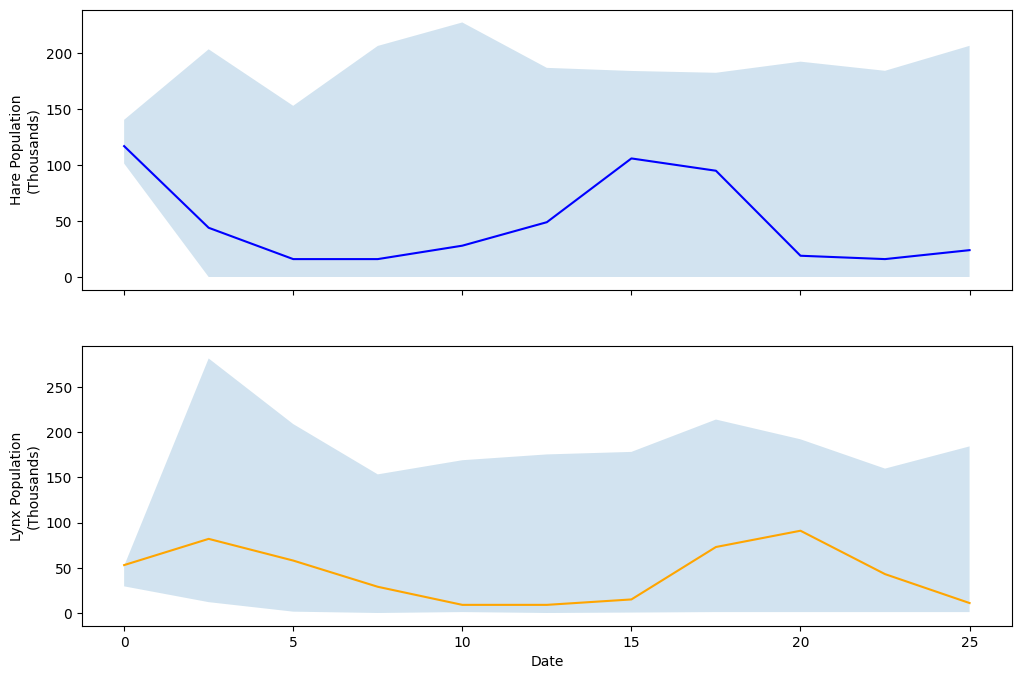

In [ ]:
# Build posterior predictive array directly from accepted simulated data
posterior_predictive = np.zeros((len(accepted_sum_stats), 2, len(t_eval)))
for i in range(len(accepted_sum_stats)):
    posterior_predictive[i, :, :] = accepted_sum_stats[i]["data"]

y_hat_lb = np.percentile(posterior_predictive, 2.5, axis=0)
y_hat_ub = np.percentile(posterior_predictive, 97.5, axis=0)

# Overlay the posterior predictive 95% CI atop the data
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(t_eval, dataDeterminism["data"][0, :], 'blue')
axes[0].fill_between(t_eval, y_hat_lb[0, :], y_hat_ub[0, :], alpha=0.2)
axes[0].set_ylabel("Hare Population\n(Thousands)")

axes[1].plot(t_eval, dataDeterminism["data"][1, :], 'orange')
axes[1].fill_between(t_eval, y_hat_lb[1, :], y_hat_ub[1, :], alpha=0.2)
axes[1].set_ylabel("Lynx Population\n(Thousands)")
axes[1].set_xlabel("Date")

Well that's not very good! For a high epsilon, the approximation to the posterior is poor and so the accecpted simulations look nothing like the target data. In the code block above, what happens if you change epsilon to a lower number, say 0.25? How do the values of the posterior look compared to the ground truth values?

Simply picking an epsilon threshold out of thin air isn't very principled... Given this is simulated data, let's get an idea of what the distribution of distances to the target data looks like when compuated at the ground truth parameter value.

Text(0, 0.5, 'Probability density')

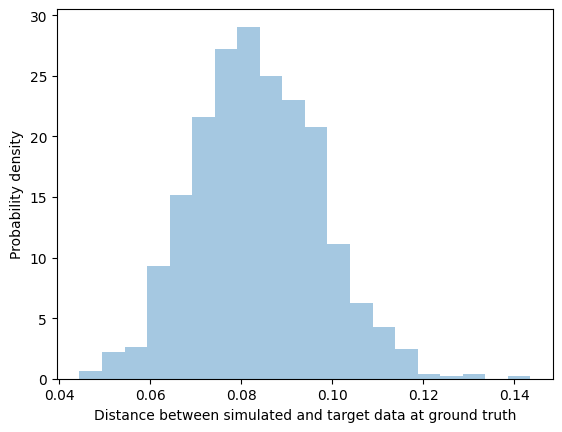

In [ ]:
distances = [distance(model({"alpha":alphaTrue,
                             "gamma":gammaTrue,
                             "beta":betaTrue},
                            constants),
                      dataDeterminism) for i in range(1000)]

fig, ax = plt.subplots()
plt.hist(distances, 20, alpha = 0.4, density = True)
plt.xlabel("Distance between simulated and target data at ground truth")
plt.ylabel("Probability density")

Okay, so let's set our distance threshold to 0.1

In [ ]:
accepted_params, accepted_sum_stats, accepted_ds, n_tries = rejection_abc(
    model=model,
    distance=distance,
    x0=dataDeterminism,
    constants=constants,
    rng=rng,
    epsilon=0.1,
    n_accept=100,
    max_tries=10_000,
    verbose=True,
)

print(f"\nTotal tries: {n_tries:,}")
print(f"Accepted: {len(accepted_params)}")
print(f"Acceptance rate: {len(accepted_params)/n_tries:.4f}")

tries=1,000  accepted=0  acc_rate=0.0000
tries=2,000  accepted=1  acc_rate=0.0005
tries=3,000  accepted=2  acc_rate=0.0007
tries=4,000  accepted=2  acc_rate=0.0005
tries=5,000  accepted=2  acc_rate=0.0004
tries=6,000  accepted=2  acc_rate=0.0003
tries=7,000  accepted=2  acc_rate=0.0003
tries=8,000  accepted=2  acc_rate=0.0003
tries=9,000  accepted=4  acc_rate=0.0004
tries=10,000  accepted=4  acc_rate=0.0004
Stopped early: only accepted 4 / 100 within 10,000 tries. Consider increasing epsilon.

Total tries: 10,000
Accepted: 4
Acceptance rate: 0.0004


So reducing our epsilon threshold to a very small cutoff with the intention of better approximating the true posterior has dramatically reduced the acceptance rate! ABC-SMC is an alternate algorithm which uses increasingly smaller epsilon windows to iteratively "zoom-in" on the appropriate region of parameter space. If you're interested in the details of how it works, see this review by Mark Beaumont: https://gwern.net/doc/statistics/bayes/abc/2019-beaumont.pdf

Rather than implement our own ABC-SMC algorithm, we're going to use the version within pyABC (https://pyabc.readthedocs.io/en/latest/). In the interest of time, let's set 100 ABC points (in a real run, you'd probably want more)

In [ ]:
pop_size = 100

# We must now define the prior distribution using pyabc's Distribution class
prior = pyabc.Distribution(alpha=pyabc.RV("lognorm", log_std_alpha,
                                          scale=np.exp(log_mean_alpha)),
                          gamma=pyabc.RV("lognorm", log_std_gamma,
                                         scale=np.exp(log_mean_gamma)),
                          beta=pyabc.RV("lognorm", log_std_beta,
                                        scale=np.exp(log_mean_beta)))

modelWrapper = lambda parameters: model(parameters, constants)
abc = pyabc.ABCSMC(modelWrapper, prior, distance, population_size=pop_size)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
INFO:ABC.Sampler:Parallelize sampling on 2 processes.


In [ ]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
abc.new("sqlite:///" + db_path, dataDeterminism)

ABC.History INFO: Start <ABCSMC id=1, start_time=2026-01-06 13:11:56>
INFO:ABC.History:Start <ABCSMC id=1, start_time=2026-01-06 13:11:56>


Let's run the actual ABC step (this took about 2 minutes when I ran this code)

In [ ]:
history = abc.run(minimum_epsilon=0.07, max_nr_populations=20)

ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.06666024e+00.
INFO:ABC:t: 0, eps: 1.06666024e+00.
ABC INFO: Accepted: 100 / 200 = 5.0000e-01, ESS: 1.0000e+02.
INFO:ABC:Accepted: 100 / 200 = 5.0000e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 5.31726449e-01.
INFO:ABC:t: 1, eps: 5.31726449e-01.
ABC INFO: Accepted: 100 / 186 = 5.3763e-01, ESS: 6.3107e+01.
INFO:ABC:Accepted: 100 / 186 = 5.3763e-01, ESS: 6.3107e+01.
ABC INFO: t: 2, eps: 4.14013054e-01.
INFO:ABC:t: 2, eps: 4.14013054e-01.
ABC INFO: Accepted: 100 / 334 = 2.9940e-01, ESS: 6.7927e+01.
INFO:ABC:Accepted: 100 / 334 = 2.9940e-01, ESS: 6.7927e+01.
ABC INFO: t: 3, eps: 3.40425329e-01.
INFO:ABC:t: 3, eps: 3.40425329e-01.
ABC INFO: Accepted: 100 / 491 = 2.0367e-01, ESS: 8.6961e+01.
INFO:ABC:Accepted: 100 / 491 = 2.0367e-01, ESS: 8.6961e+01.
ABC INFO: t: 4, eps: 2.82528141e-01.
INFO:ABC:t: 4, eps: 2.82528141e-01.
ABC INFO: Accepted: 100 / 257 = 3.8911e-01, ESS: 6.8107e+01.
INFO:ABC:Accepted

Have the retained simulation converged around the ground truth?

Posterior summary - Median (95% CI)
alpha: 0.359 (0.327 - 0.390)
beta: 0.010 (0.009 - 0.011)
gamma: 0.494 (0.465 - 0.530)


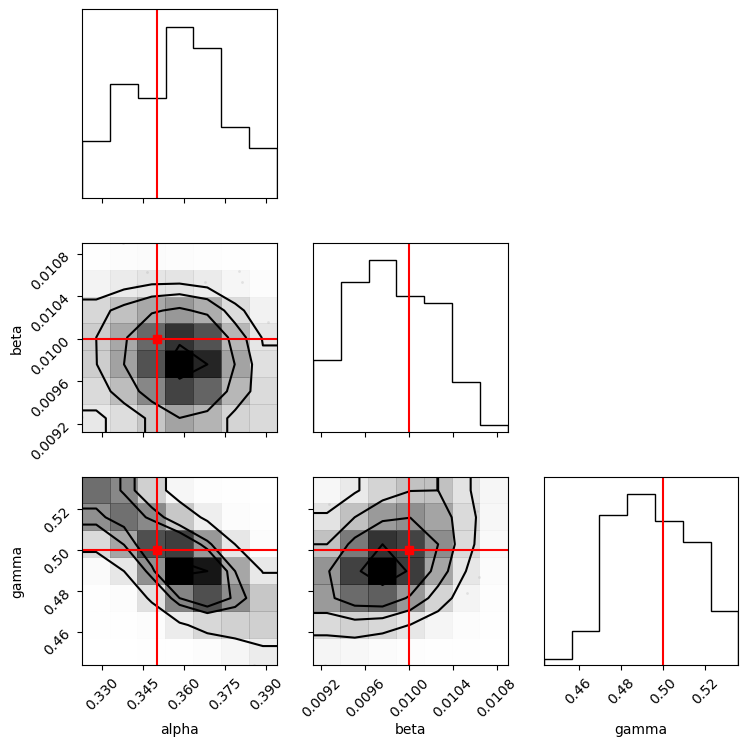

In [ ]:
posterior, w = history.get_distribution(m=0)

posterior_median = posterior.median()
posterior_lb = posterior.quantile(0.025)
posterior_ub = posterior.quantile(0.975)

print("Posterior summary - Median (95% CI)")
for col in posterior.columns:
    print(f"{col}: {posterior_median[col]:.3f} ({posterior_lb[col]:.3f} - {posterior_ub[col]:.3f})")

truth_dict = {
    "alpha":alphaTrue,
    "beta":betaTrue,
    "gamma":gammaTrue
}
truth = [truth_dict[col] for col in posterior.columns]

ndims = np.shape(posterior)[1]

# Make the base corner plot
figure = corner.corner(posterior.values, bins=7, smooth=1, labels=posterior.columns)
# Extract the axes
axes = np.array(figure.axes).reshape((ndims, ndims))
# Loop over the diagonal
for i in range(ndims):
    ax = axes[i, i]
    ax.axvline(truth[i], color="r")
# Loop over the histograms
for yi in range(ndims):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(truth[xi], color="r")
        ax.axhline(truth[yi], color="r")
        ax.plot(truth[xi], truth[yi], "sr")
plt.tight_layout()

Great, so our posterior contains the ground truth! How well have we zoomed in on the ground truth compared to the prior?

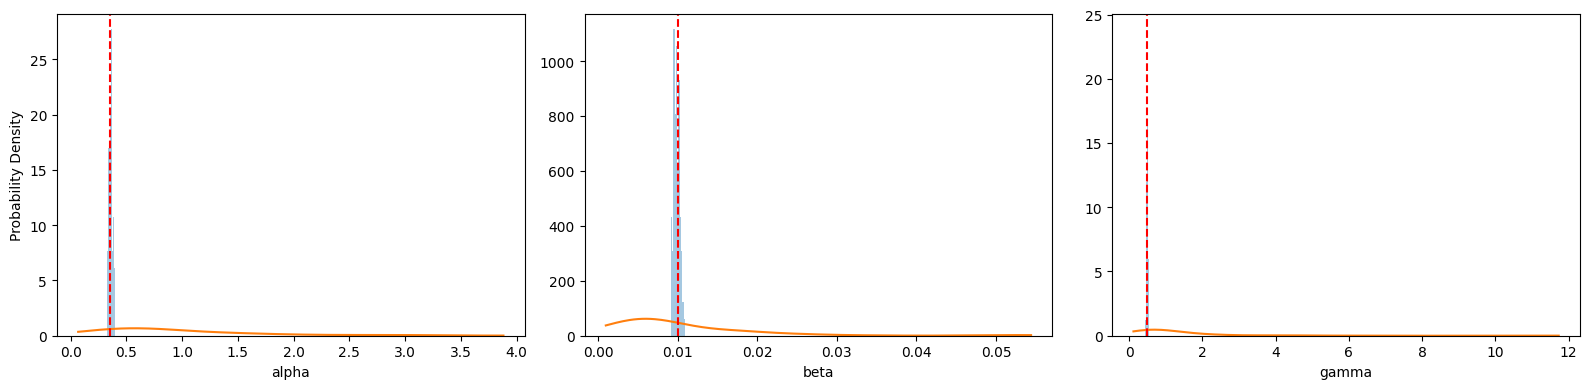

In [ ]:
prior_samples = prior.rvs(100)
prior_samples

fig, axes = plt.subplots(1, ndims, figsize = (16, 4))
for i, var in enumerate(posterior.columns):
    axes[i].hist(posterior.values[:, i], bins=11, alpha=0.4, density=True)
    sns.kdeplot(prior_samples[var], ax = axes[i], cut = 0)
    axes[i].axvline(x=truth_dict[var], linestyle = '--',
                    color = 'red')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('')
axes[0].set_ylabel('Probability Density')
plt.tight_layout()

So using ABC-SMC, we can infer the prey's growth rate and the predator's death rate using the classical Lotka Volterra model!

Having fit our model to data, it is important to check that our model actually does a good job of fitting the data. Obviously, in this case, we defined the model and then drew our data from it, so we know it should be a reasonable fit, but in the case when we're fitting a model to real data this won't necessarily be the case. To compare our model to data, we can overlay the posterior predictive (i.e. the 95% credible interval of our simulated data) atop the target data.

First, let's extract the simulated data for each accepted point in the posterior and wrangle it into a more usable shape

In [ ]:
posterior_predictive = np.zeros((pop_size, 2, len(t_eval)))

samples_list = history.get_population().get_accepted_sum_stats()
for i in range(len(samples_list)):
    posterior_predictive[i, :, :] = samples_list[i]["data"]

Now, let's calculate the median of the posterior predictive and the 95% credible interval

Text(0.5, 0, 'Date')

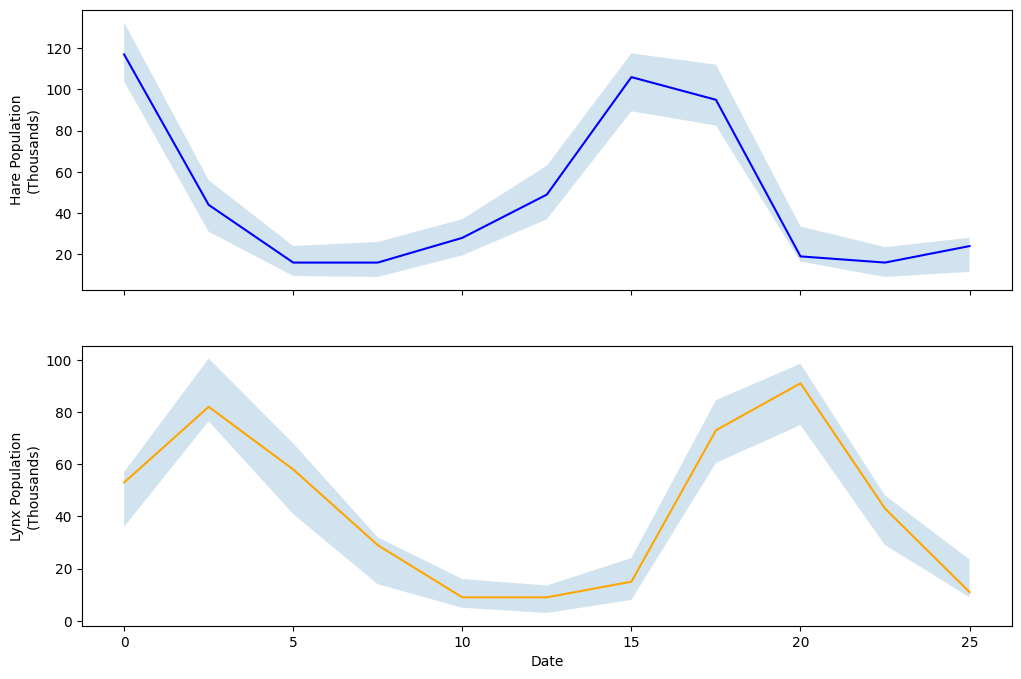

In [ ]:
y_hat_lb = np.percentile(posterior_predictive, 2.5, axis = 0)
y_hat_ub = np.percentile(posterior_predictive, 97.5, axis = 0)

# Overlay the posterior predictive 95% CI atop the data
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(t_eval, dataDeterminism["data"][0, :], 'blue')
axes[0].fill_between(t_eval, y_hat_lb[0, :], y_hat_ub[0, :], alpha=0.2)
axes[0].set_ylabel("Hare Population\n(Thousands)")

axes[1].plot(t_eval, dataDeterminism["data"][1, :], 'orange')
axes[1].fill_between(t_eval, y_hat_lb[1, :], y_hat_ub[1, :], alpha=0.2)
axes[1].set_ylabel("Lynx Population\n(Thousands)")
axes[1].set_xlabel("Date")

As expected, the posterior predictive looks to overlap the target data, so we can be pretty confident that our model well represents the data.

As well as inferring the parameters of a given model, another important task is deciding which model from a set of competing models, fits the data the best (whilst penalising increasingly complex models). There are a plethora of approaches, but one approach is to use the ratio of the fraction of accepted points for a given epsilon as an approximation of the Bayes Factor. This can be implemented within the pyABC ABC-SMC framework.

In the classic Lotka Voltera model, prey are expected to grow exponentially in the absence of predators, unbounded by, for example, food. A biologically relevant alternative to the classic Lotka Volterra model is to include a carrying capacity ($Κ$) into the prey population.
$$\frac{dx}{dt}=\alpha x\left(1-\frac{x}{Κ}\right) - \beta x y$$
$$\frac{dy}{dt}=\delta x y - \gamma y$$

This represent's the dynamics of the prey being limited by the constraints in the environment, such that in the absence of predators, the prey population tends to $Κ$, rather than $∞$.

In [ ]:
def LotkaVolterraCarrCapODE(t, x_y, alpha, beta, delta, gamma, kappa):
    """
    Calculate d([x, y])/dt for the Lotka Volterra system
    with a logistic prey growth term.

    Parameters
    ----------
    t : float
        Time (required by odeint function).
    x_y : [float, float]
        Populations array (prey, predator).
    alpha : float
        Prey growth rate.
    beta : float
        Prey death rate per predator.
    delta : float
        Predator growth rate per prey.
    gamma : float
        Predator death rate.
    kappa : float
        Prey carrying capacity.


    Returns
    -------
    [float, float]
        The instantaneous rate of change of the prey and
        predator populations.
    """
    x, y = x_y

    dx_dt = alpha * x * (1 - x / kappa) - beta * x * y
    dy_dt = delta * x * y - gamma * y

    return np.array([dx_dt, dy_dt])

def LotkaVolterraCarrCapDeterministic(
        params,
        InitialConditions,
        t
    ):
    """
    Integrate the Lotka Volterra system given a set of
    parameters and initial conditions at times t.

    Parameters
    ----------
    params : np.array([alpha, beta, delta, gamma, kappa])
        The prey growth rate, prey death rate per
        predator, predator growth rate per prey,
        predator death rate and prey carrying capacity.
    InitialConditions : [float, float]
        Populations array (prey, predator) at time t[0].
    t : np.array([float, float, ...])
        Times at which to evaluate system.

    Returns
    -------
    np.array([float, float, ...])
        The prey and predators populations evaluated at
        times t.
    """

    tspan = (np.min(t), np.max(t))

    out = solve_ivp(LotkaVolterraCarrCapODE, tspan,
                InitialConditions, t_eval=t,
                args=params,
                method='RK45', rtol=10**-6)

    out['y'][out['y'] < 0.0] = 0.0

    return out['y']

def LotkaVolterraCarrCapDeterministicError(
        params,
        InitialConditions,
        t,
        rng=None
    ):
    """
    Function to integrate the Lotka Volterra ODE with
    a logistic prey growth term and add Poisson distributed
    noise on top.

    Parameters
    ----------
    params : np.array([alpha, beta, delta, gamma, kappa])
        The prey growth rate, prey death rate per
        predator, predator growth rate per prey,
        predator death rate and prey carrying capacity.
    InitialConditions : [float, float]
        Populations array (prey, predator) at time t[0].
    t : np.array([float, float, ...])
        Times at which to evaluate system.
    rng : np.random.default_rng()
        Numpy random generator

    Returns
    -------
    np.array([float, float, ...])
        The noisy prey and predators populations
        evaluated at times t.
    """
    if rng is None:
        rng = np.random.default_rng()

    xy = LotkaVolterraCarrCapDeterministic(params, InitialConditions, t)

    return rng.poisson(xy)

def model2(parameters, constants):
    """
    Wrapper function to simulate the deterministic Lotka
    Volterra system in the syntax pyabc expects (e.g.
    with the parameters parcelled into a dictionary and
    the output returned as a dictionary).

    Parameters
    ----------
    parameters : dict
        Dictionary containing:
            "alpha" : the prey growth rate,
            "beta" : prey death rate per predator,
            "gamma" : predator death rate,
            "kappa" : prey carrying capacity.
    constants : [float, np.array(float, float, ...),
                        np.random.default_rng()]
        List containing the populations array
        (prey, predator) at time t[0], the times
        at which to evaluate system and a Numpy
        random generator.

    Returns
    -------
    dict()
        Dictionary containing the noisy prey and predators
        populations evaluated at times t.
    """
    alpha = parameters["alpha"]
    gamma = parameters["gamma"]
    beta = parameters["beta"]
    kappa = parameters["kappa"]
    delta = beta

    InitialConditions, t, rng = constants

    PreyPredErr = LotkaVolterraCarrCapDeterministicError(
                                  [alpha, beta, delta, gamma,kappa],
                                  InitialConditions, t, rng)
    return {"data": PreyPredErr}

(0.0, 125.22538010739916)

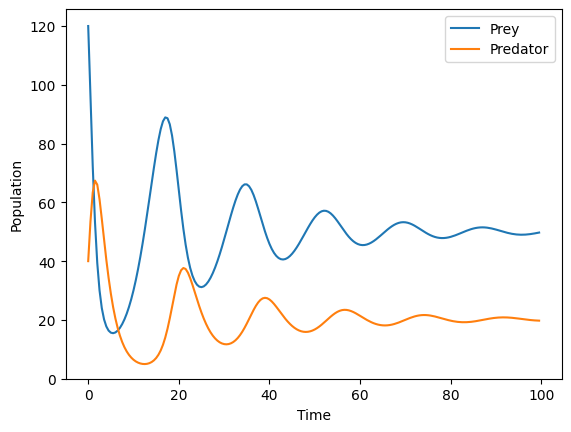

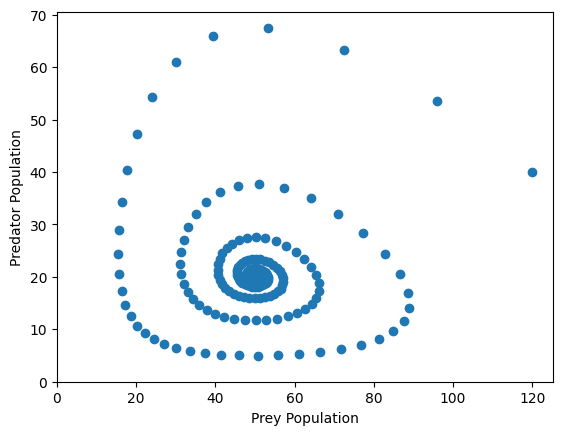

In [ ]:
alpha = 0.35
beta = 1.3 * 10**-2
delta = 1 * 10**-2
gamma = 0.5
kappa = 200

t = np.arange(0, 100, 0.5)

InitialConditions = np.array([120, 40])

PreyPred = LotkaVolterraCarrCapDeterministic(
        [alpha, beta, delta, gamma, kappa],
        InitialConditions,
        t
    )

fig, ax = plt.subplots()
a = plt.plot(t, PreyPred[0, :])
b = plt.plot(t, PreyPred[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
a = plt.scatter(PreyPred[0, :], PreyPred[1, :])
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

So the carrying capacity term effectively dampens the system. For sufficiently small carrying capacities the system converges to a stable fixed point, while larger carrying capacities can support persistent oscillations.

Let's generate some data from the more complex model over the same limited time region as in our first example.

(0.0, 130.95)

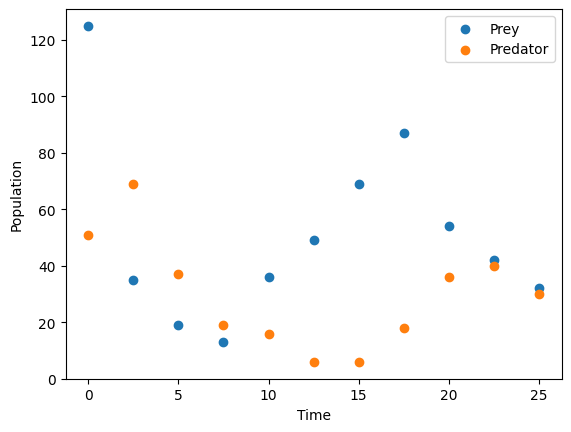

In [ ]:
kappaTrue = 200

dataCarrCap = model2({"alpha":alphaTrue, "gamma":gammaTrue,
                         "beta":betaTrue, "kappa":kappaTrue}, constants)

fig, ax = plt.subplots()
a = plt.scatter(t_eval, dataCarrCap["data"][0, :])
b = plt.scatter(t_eval, dataCarrCap["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

In the ABC-SMC framework implemented in pyABC, the model index is treated as an additional discrete parameter. At each iteration, pyABC proposes a model, samples parameters from the corresponding prior, generates simulated data using that model, and accepts or rejects the model-parameter pair based on the distance to the observed data. As the tolerance is reduced, models that generate better-fitting simulations accumulate a larger fraction of accepted particles, providing an approximation to posterior model probabilities and Bayes factors. All we need to do is pass the models and corresponding priors to pyabc.

In [ ]:
log_mean_kappa, log_std_kappa = lognormal_convert_params(mu=300, sigma=300)

# We must now define the prior distribution using pyabc's Distribution class
prior2 = pyabc.Distribution(alpha=pyabc.RV("lognorm", log_std_alpha,
                                          scale=np.exp(log_mean_alpha)),
                          gamma=pyabc.RV("lognorm", log_std_gamma,
                                         scale=np.exp(log_mean_gamma)),
                          beta=pyabc.RV("lognorm", log_std_beta,
                                        scale=np.exp(log_mean_beta)),
                          kappa=pyabc.RV("lognorm", log_std_kappa,
                                        scale=np.exp(log_mean_kappa)))

models = [lambda parameters: model(parameters, constants),
          lambda parameters: model2(parameters, constants)]
priors = [prior, prior2]

abc2 = pyabc.ABCSMC(models, priors, distance, population_size=pop_size,
                    stop_if_only_single_model_alive=True)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
INFO:ABC.Sampler:Parallelize sampling on 2 processes.


In [ ]:
db_path2 = os.path.join(tempfile.gettempdir(), "test2.db")
abc2.new("sqlite:///" + db_path2, dataCarrCap)

ABC.History INFO: Start <ABCSMC id=2, start_time=2026-01-06 13:16:41>
INFO:ABC.History:Start <ABCSMC id=2, start_time=2026-01-06 13:16:41>


In [ ]:
history2 = abc2.run(minimum_epsilon=0.07, max_nr_populations=20)

ABC INFO: t: 0, eps: 7.58630381e-01.
INFO:ABC:t: 0, eps: 7.58630381e-01.
ABC INFO: Accepted: 100 / 226 = 4.4248e-01, ESS: 1.0000e+02.
INFO:ABC:Accepted: 100 / 226 = 4.4248e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.91974191e-01.
INFO:ABC:t: 1, eps: 3.91974191e-01.
ABC INFO: Accepted: 100 / 248 = 4.0323e-01, ESS: 3.0579e+01.
INFO:ABC:Accepted: 100 / 248 = 4.0323e-01, ESS: 3.0579e+01.
ABC INFO: t: 2, eps: 3.05170391e-01.
INFO:ABC:t: 2, eps: 3.05170391e-01.
ABC INFO: Accepted: 100 / 418 = 2.3923e-01, ESS: 5.5519e+01.
INFO:ABC:Accepted: 100 / 418 = 2.3923e-01, ESS: 5.5519e+01.
ABC INFO: t: 3, eps: 2.68356460e-01.
INFO:ABC:t: 3, eps: 2.68356460e-01.
ABC INFO: Accepted: 100 / 290 = 3.4483e-01, ESS: 4.3233e+01.
INFO:ABC:Accepted: 100 / 290 = 3.4483e-01, ESS: 4.3233e+01.
ABC INFO: t: 4, eps: 2.23262505e-01.
INFO:ABC:t: 4, eps: 2.23262505e-01.
ABC INFO: Accepted: 100 / 414 = 2.4155e-01, ESS: 3.1897e+01.
INFO:ABC:Accepted: 100 / 414 = 2.4155e-01, ESS: 3.1897e+01.
ABC INFO: t: 5, eps: 1.8740213

 Let's see how the model probabilities changed over the course of the decreasing epsilon curoffs.

m         0         1
t                    
0  0.240000  0.760000
1  0.144037  0.855963
2  0.165833  0.834167
3  0.121124  0.878876
4  0.089133  0.910867
5  0.076594  0.923406
6  0.000025  0.999975
7  0.023851  0.976149
8  0.003875  0.996125
9  0.000000  1.000000


<Axes: title={'center': 'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

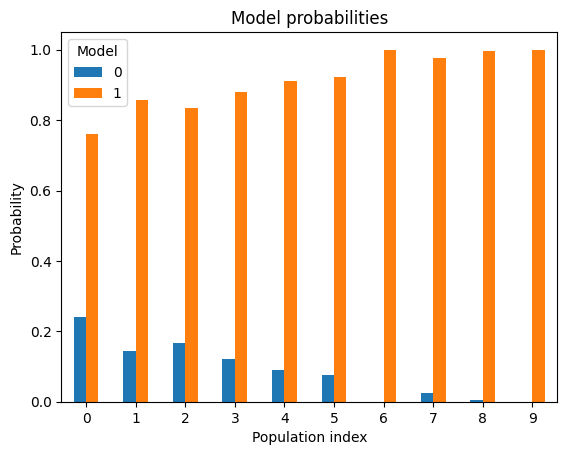

In [ ]:
# Evaluate the model probabililties
history2 = abc2.history
model_probabilities = history2.get_model_probabilities()
print(model_probabilities)

pyabc.visualization.plot_model_probabilities(history2)

So the ABC-SMC model selection strongly preferred the correct carrying capacity version, matching the ground truth model. Note though, that for the purposes of the demo we set `stop_if_only_single_model_alive=True`, but the approximation to Bayes factors is only valid in the limit $\epsilon → ∞$, so in a real use case we'd want to run the system for our full epsilon schedule.

The deterministic Lotka Volterra model does a pretty good job capturing certain features of the predator-prey dynamics; however it is also quite unrealistic. For instance, the classic model does not allow extinction to occur - a population can get asymptotically close to 0 before recovering.

(0.0, 312.5824799843985)

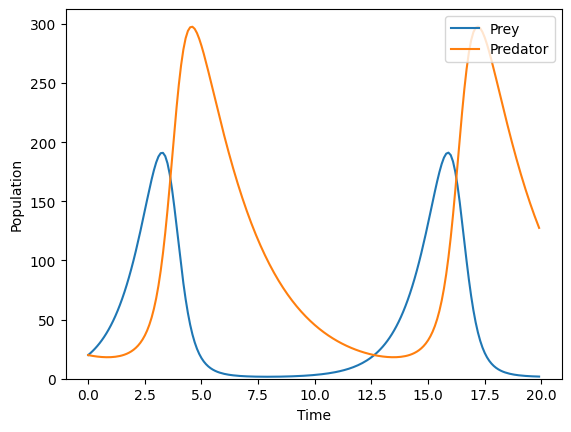

In [ ]:
alphaExtinc = 1
betaExtinc = 10**-2
deltaExtinc = 10**-2
gammaExtinc = 0.4

t = np.arange(0, 20, 0.1)

InitialConditionsExtinc = np.array([20, 20])

PreyPredExtinc = LotkaVolterraDeterministic(
        [alphaExtinc, betaExtinc, deltaExtinc, gammaExtinc],
        InitialConditionsExtinc,
        t
    )

fig, ax = plt.subplots()
a = plt.plot(t, PreyPredExtinc[0, :])
b = plt.plot(t, PreyPredExtinc[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

One way to allow for extinction is to turn to a stochastic model, whereby the number of predator and prey are represented by discrete random variables evolving randomly over time. This accounts for both the discrete nature of the problem and random fluctuations.

Theoretically, one could write down the Master equation of the two-dimensional Markov chain that governs this system and attempt to solve it; however, this is computationally difficult, as there are infinite possible states (among other reasons). An alternative approach is to generate a simulation of the predator-prey dynamics that follows the same dynamics as the stochastic Lotka Volterra system.

In the interest of time, I've written a stochastic Gillespie simulation (https://en.wikipedia.org/wiki/Gillespie_algorithm) to model the evolution of the discrete prey and predator populations. For simplicity we've assumed that $\delta=\beta$, so that whenever a prey is consumed a predator gives birth.  The basic structure of the model is to calculate the waiting time until either a prey is born, a predator comsumes a prey and expands or a predator dies. If the waiting time lies within the time interval of the simulation then the event occurs and the time is updated.

In [ ]:
def LotkaVolterraStochastic(
        params,
        InitialConditions,
        t_eval,
        rng=None):
    """
    Simulate the stochastic Lotka Volterra system
    evaluated at times t_eval.

    Parameters
    ----------
    params : np.array([alpha, beta, delta, gamma])
        The prey growth rate, prey death rate per
        predator, predator growth rate per prey and
        predator death rate.
    InitialConditions : [float, float]
        Populations array (prey, predator) at time t[0].
    t_eval : np.array([float, float, ...])
        Times at which to evaluate system.
    rng : np.random.default_rng()
        Numpy random generator


    Returns
    -------
    np.array(size=(2, len(t_eval)))
        The stochastic prey and predator populations at
        times t_eval.
    """

    if rng is None:
        rng = np.random.default_rng()

    # Unpack parameters
    alpha, beta, gamma = params

    # Initialise t variable to count the current time of the system,
    # a t_out variable to count the time of the system when the
    # output was last updated and a T variable to determine how
    # long to run the simulation for.
    t = t_eval[0]
    t_out = t_eval[0]
    T = t_eval[-1]

    # Define x_y to keep track of the populations of prey and
    # predators respectively
    x_y = InitialConditions.astype(float)

    # Preallocate output array
    out = np.zeros((2, len(t_eval)))
    out[:, 0] = InitialConditions

    # Define the three types of "events" that our model considers
    events = ['PreyGrowth', 'PredatorConsumePrey', 'PredatorDeath']

    # Use a while loop to model the simulation occurring between t_eval[0]
    # and t_eval[-1]
    while t < T:

        # If both populations have gone extinct, then we can preemptively
        # end the simulation
        if np.all(np.abs(x_y) < 0.001):
            break

        # If predators go extinct before the prey, then the prey population
        # will undergo a pure birth (Yule) process - this falls out of the
        # standard Guillespie code below, but will take an exponentially
        # long time. Instead, we will handle that case separately.

        elif abs(x_y[1]) > 0.001:

            # Calculate the rates of the possible state changes
            weights = np.array([alpha * x_y[0],
                                beta * x_y[0] * x_y[1],
                                gamma * x_y[1]])

            # We assume the events have exponential waiting times, calculate
            # the time until the next event occurs
            twait = 1 / weights.sum() * np.log(1 / random.random())

            if t + twait < T:
                # Randomly choose which event occurs
                event = random.choices(events, weights)[0]

                if event == 'PreyGrowth':
                    # Increase the prey population by 1
                    x_y[0] += 1
                elif event == 'PredatorConsumePrey':
                    # Decrease the prey population by 1 and
                    # increase the predator population by 1
                    x_y[0] -= 1
                    x_y[1] += 1
                else:
                    # Decrease the predator population by 1
                    x_y[1] -= 1

                # Increase time counter by waiting time
                t += twait

                # This next bit of code is necessary because we have a continuous
                # time model but fixed evaluation time.

                # Find the first t_eval index that is greater than the last recorded
                # time and the first t_eval index greater than the current time
                idx_t1 = next(x[0] for x in enumerate(t_eval) if x[1] > t_out)
                idx_t2 = next(x[0] for x in enumerate(t_eval) if x[1] >= t)

                # Loop between idx_t1 and idx_t2 recording all the t_eval
                # timepoints that have fallen between the last event recorded
                # and the current time
                if idx_t2 > idx_t1:
                    for idx in range(idx_t1, idx_t2):
                        out[:, idx] = x_y

                    t_out = t

            else:
                idx_t1 = next(x[0] for x in enumerate(t_eval) if x[1] > t_out)
                for idx in range(idx_t1, len(t_eval)):
                    out[:, idx] = x_y
                break

        else:
            # If the predator population goes extinct, we will use the known
            # fact that the population j at time t2 for a pure birth process
            # with initial population i at time t1 follows a negative
            # binomial distribution with parameters i and exp(-alpha * (t2-t1))

            if t >= T:
                break

            # Find the next timepoint to be evaluated
            idx_t = next(x[0] for x in enumerate(t_eval) if x[1] > t)
            t_next = t_eval[idx_t]
            dt = t_next - t

            try:
                # The numpy negative binomial distribution is susceptible
                # to overflow (silently!), so once X is very large just
                # assume that the growth is deterministically exponential
                dPrey = rng.negative_binomial(int(x_y[0]), np.exp(-alpha*dt ))
                if dPrey >= 0:
                    x_y[0] += dPrey
                else:
                    x_y[0] *= np.exp(alpha * dt)
            except OverflowError as e:
                x_y[0] = sys.float_info.max

            out[:, idx_t] = x_y

            t += dt

    return out

In [ ]:
rng = np.random.default_rng()
t_eval = np.linspace(0, 25, 11)
%timeit LotkaVolterraStochastic([alphaExtinc, betaExtinc, gammaExtinc], InitialConditionsExtinc, t_eval, rng)

44 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's run the simulation a few times and plot the results!

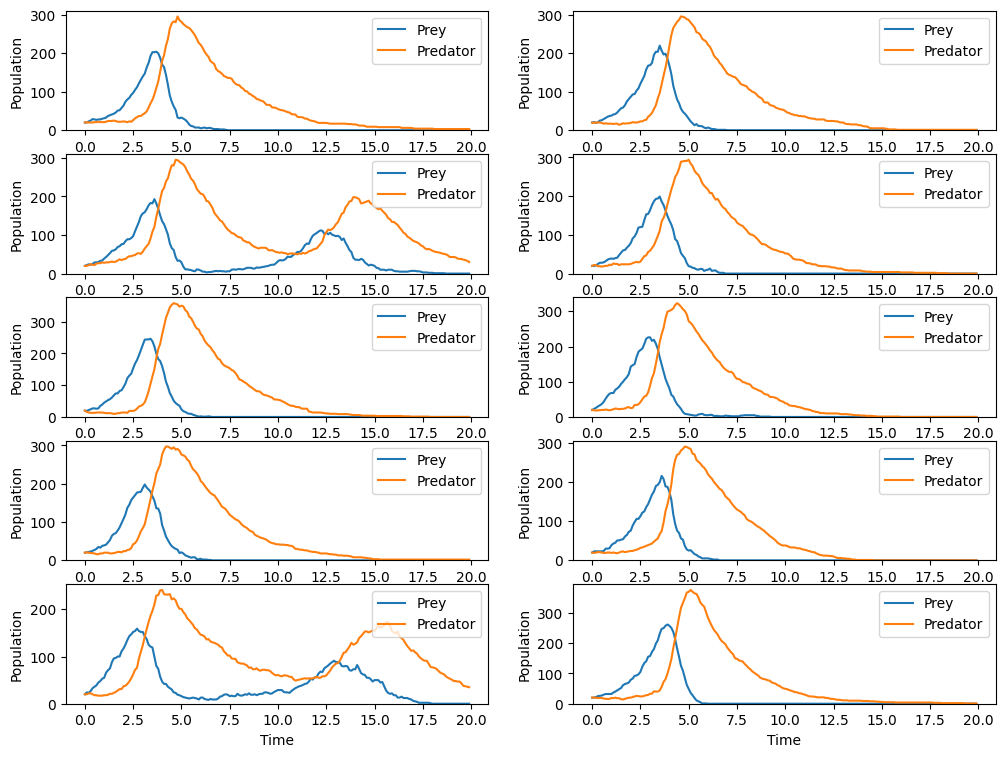

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 9))
axes = np.ravel(axes)
for i in range(10):
    PreyPredStoch = LotkaVolterraStochastic(
            [alphaExtinc, betaExtinc, gammaExtinc],
            InitialConditionsExtinc,
            t, rng
        )

    ax = axes[i]
    a = ax.plot(t, PreyPredStoch[0, :])
    b = ax.plot(t, PreyPredStoch[1, :])
    ax.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
                loc='upper right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_ylim(bottom=0)

There are some important similarities and differences when comparing the stochastic and discrete model. Namely, the stochastic model now allows for extinctions to occur, but if an extinction does not occur near the trough of the distribution, the stochastic model looks qualitatively similar to the deterministic model (e.g. similar periodicity and amplitude of oscillation). The output of the stochastic model varies from run to run, even without adding any additional measurement error.

Now try running the above code with $\alpha=2.0$ and $\gamma=2.0$, what do you notice about some of the simulations?

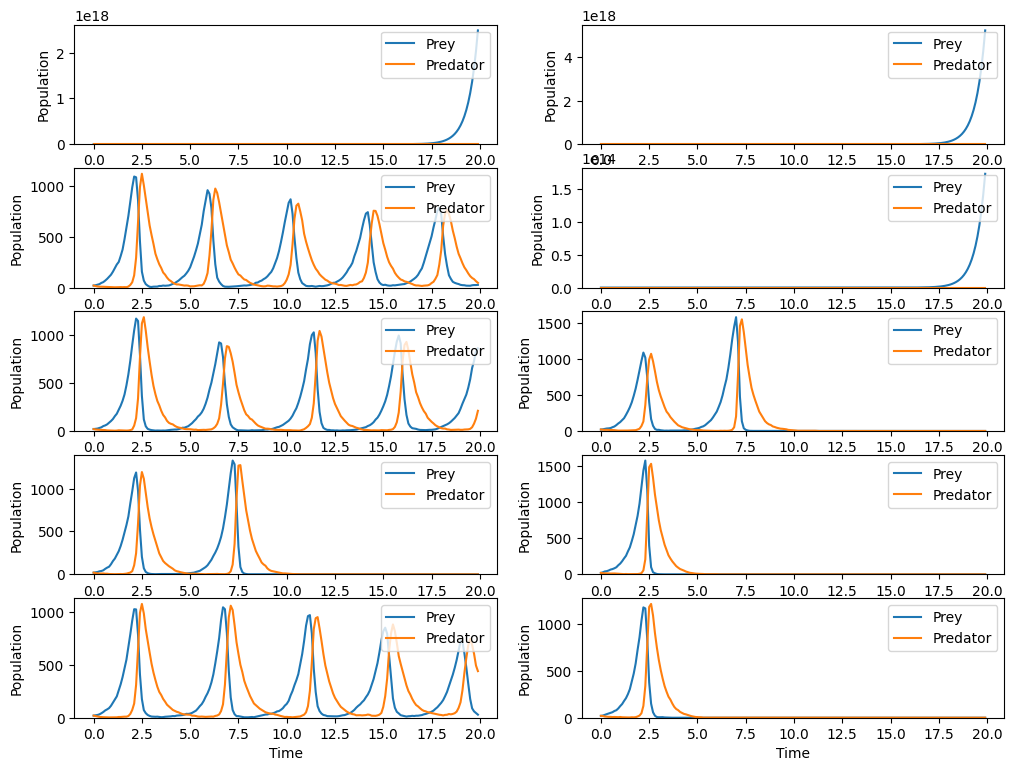

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 9))
axes = np.ravel(axes)
for i in range(10):
    PreyPredStoch = LotkaVolterraStochastic(
            [2.0, betaExtinc, 2.0],
            InitialConditionsExtinc,
            t
        )

    ax = axes[i]
    a = ax.plot(t, PreyPredStoch[0, :])
    b = ax.plot(t, PreyPredStoch[1, :])
    ax.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
                loc='upper right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_ylim(bottom=0)

Because we can only simulate our model, not write down a closed form likelihood, this is a perfect model to use ABC on!

I've generated some data using some hidden parameters for $\alpha$, $\beta$ and $\gamma$ and saved it at LotkaVolterraStochastic.csv - let's load it in and plot it

File not found locally, loading from Github directly instead


(0.0, 277.2)

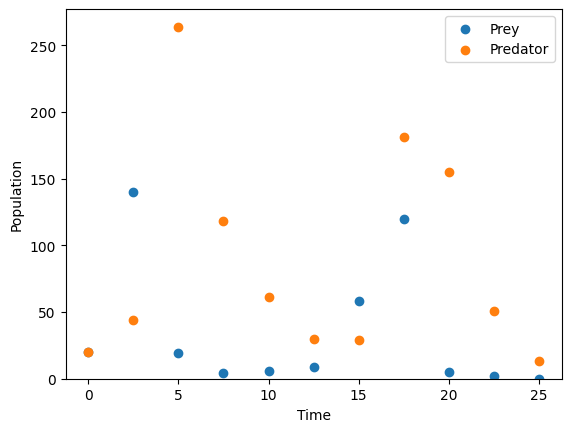

In [ ]:
# load data - if not availible locally, pull from Github directly
try:
  df = pd.read_csv("LotkaVolterraStochastic.csv")
except FileNotFoundError:
  print("File not found locally, loading from Github directly instead")
  df = pd.read_csv("https://raw.githubusercontent.com/CalumGabbutt/FitModelsData/main/LotkaVolterraStochastic.csv")

dataStochastic = {"data":df[["prey", "predator"]].values.transpose()}
t_eval = df['t'].values
constantsStochastic = [InitialConditionsExtinc, t_eval, rng]

fig, ax = plt.subplots()
a = plt.scatter(t_eval, dataStochastic["data"][0, :])
b = plt.scatter(t_eval, dataStochastic["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

Here, you can copy and paste the above ABC model code for the determinstic Lotka Volterra model and modify it to reference the data as dataStochastic and the stochastic version of the Lotka Volterra model. I suggest you change the minimum_epsilon to 0.1 and the pop_size to 50, as the stochastic simulation is more computationally expensive and harder to fit, and we want the inference to finish reasonably quickly.

# Additional Exercises

The following is material that we're unlikely to cover during the session, but may be important to consider when fitting data to real world models.

Naively, one may expect that as you increase the amount of data you are fitting your model to, the easier it becomes to fit. One of the difficulties of ABC is that as you increase the number of stochastic datapoints you are fitting, the less likely that your simulation outputs are very close to all of them at once, and so it can take an exponentially longer time to fit your model. This is known as the curse of dimensionality.

Let's think about fitting a 2D Gaussian distribution with 100 data points

In [ ]:
def modelGauss(parameters, constants):
    """
    Wrapper function to draw a number of normally
    distributed sample in the syntax pyabc expects (e.g.
    with the parameters parcelled into a dictionary and
    the output returned as a dictionary).

    Parameters
    ----------
    parameters : dict
        Dictionary containing:
            "mu1" : the mean of the first dimension,
            "mu2" : the mean of the second dimension,
            "sigma1" : the standard deviation of the first
                        dimension,
            "sigma2" : the standard deviation of the second
                        dimension.
    constants : [(int, int), np.random.default_rng()]
        List containing the size of the output samples and
        a Numpy random generator.

    Returns
    -------
    dict()
        Dictionary containing the 2D Gaussian samples
        evaluated at the input parameters.
    """
    mu1 = parameters["mu1"]
    mu2 = parameters["mu2"]
    sigma1 = parameters["sigma1"]
    sigma2 = parameters["sigma2"]

    # size must be (number of data points, number of dimensions)
    size, rng = constants

    return {"data": rng.normal(loc=[mu1, mu2], scale=[sigma1, sigma2], size=size)}

Text(0, 0.5, 'y2')

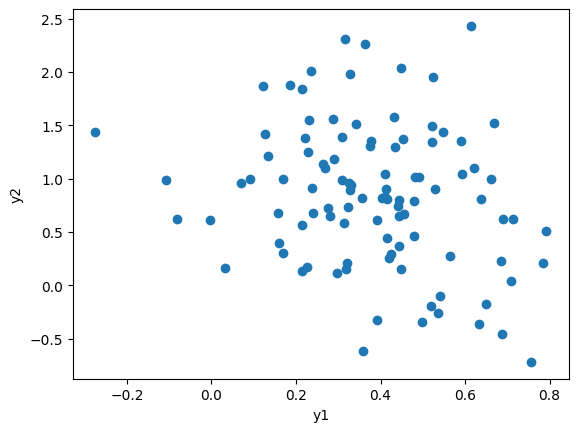

In [ ]:
sizeGauss = (100, 2)
constantsGauss = [sizeGauss, np.random.default_rng()]
paramsTrue = {"mu1":0.4, "mu2":0.8, "sigma1":0.2, "sigma2":0.6}
dataGauss = modelGauss(paramsTrue, constantsGauss)

fig, ax = plt.subplots()
plt.scatter(dataGauss["data"][:, 0], dataGauss["data"][:, 1])
plt.xlabel("y1")
plt.ylabel("y2")

Text(0, 0.5, 'Probability density')

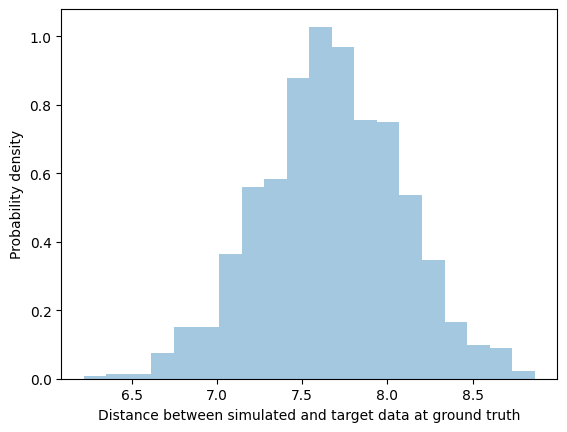

In [ ]:
distancesGauss = [distance(modelGauss(paramsTrue, constantsGauss), dataGauss) for i in range(1000)]

fig, ax = plt.subplots()
plt.hist(distancesGauss, 20, alpha = 0.4, density = True)
plt.xlabel("Distance between simulated and target data at ground truth")
plt.ylabel("Probability density")

In [ ]:
priorGauss = pyabc.Distribution(mu1=pyabc.RV("norm"),
                                mu2=pyabc.RV("norm"),
                                sigma1=pyabc.RV("truncnorm", 0.0, np.inf),
                                sigma2=pyabc.RV("truncnorm", 0.0, np.inf))

In [ ]:
modelWrapperGauss = lambda parameters: modelGauss(parameters, constantsGauss)
popSizeGauss = 500
abcGauss = pyabc.ABCSMC(modelWrapperGauss, priorGauss, distance, population_size=popSizeGauss)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
INFO:ABC.Sampler:Parallelize sampling on 2 processes.


In [ ]:
db_pathGauss = os.path.join(tempfile.gettempdir(), "Gauss.db")
abcGauss.new("sqlite:///" + db_pathGauss, dataGauss)

ABC.History INFO: Start <ABCSMC id=1, start_time=2026-01-06 13:19:47>
INFO:ABC.History:Start <ABCSMC id=1, start_time=2026-01-06 13:19:47>


In [ ]:
historyGauss = abcGauss.run(minimum_epsilon=5.0, max_nr_populations=20)

ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.70827123e+01.
INFO:ABC:t: 0, eps: 1.70827123e+01.
ABC INFO: Accepted: 500 / 1024 = 4.8828e-01, ESS: 5.0000e+02.
INFO:ABC:Accepted: 500 / 1024 = 4.8828e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 1.36270085e+01.
INFO:ABC:t: 1, eps: 1.36270085e+01.
ABC INFO: Accepted: 500 / 1142 = 4.3783e-01, ESS: 4.3845e+02.
INFO:ABC:Accepted: 500 / 1142 = 4.3783e-01, ESS: 4.3845e+02.
ABC INFO: t: 2, eps: 1.12707126e+01.
INFO:ABC:t: 2, eps: 1.12707126e+01.
ABC INFO: Accepted: 500 / 1093 = 4.5746e-01, ESS: 4.0293e+02.
INFO:ABC:Accepted: 500 / 1093 = 4.5746e-01, ESS: 4.0293e+02.
ABC INFO: t: 3, eps: 9.80759486e+00.
INFO:ABC:t: 3, eps: 9.80759486e+00.
ABC INFO: Accepted: 500 / 990 = 5.0505e-01, ESS: 4.3271e+02.
INFO:ABC:Accepted: 500 / 990 = 5.0505e-01, ESS: 4.3271e+02.
ABC INFO: t: 4, eps: 8.68970630e+00.
INFO:ABC:t: 4, eps: 8.68970630e+00.
ABC INFO: Accepted: 500 / 1149 = 4.3516e-01, ESS: 4.3074e+02.
INFO:ABC:A

So how has our ABC fit done?

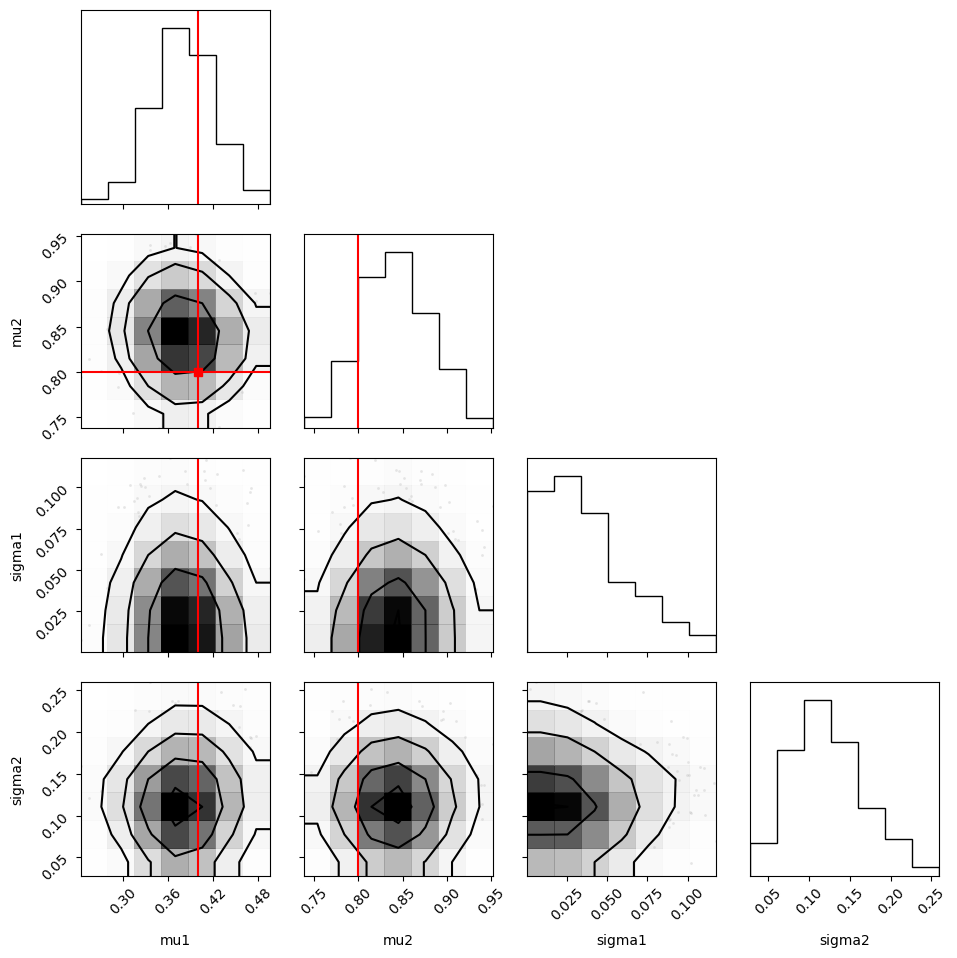

In [ ]:
posteriorGauss, wGauss = historyGauss.get_distribution(m=0)
# truth = [alphaTrue, betaTrue, gammaTrue]

ndimsGauss = np.shape(posteriorGauss)[1]

truthGauss = [paramsTrue[col] for col in posteriorGauss.columns]

# Make the base corner plot
figure = corner.corner(posteriorGauss.values, bins=7, smooth=1, labels=posteriorGauss.columns)
# Extract the axes
axes = np.array(figure.axes).reshape((ndimsGauss, ndimsGauss))
# Loop over the diagonal
for i in range(ndimsGauss):
    ax = axes[i, i]
    ax.axvline(truthGauss[i], color="r")
# Loop over the histograms
for yi in range(ndimsGauss):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(truthGauss[xi], color="r")
        ax.axhline(truthGauss[yi], color="r")
        ax.plot(truthGauss[xi], truthGauss[yi], "sr")
plt.tight_layout()

The curse of dimensionality strikes again!

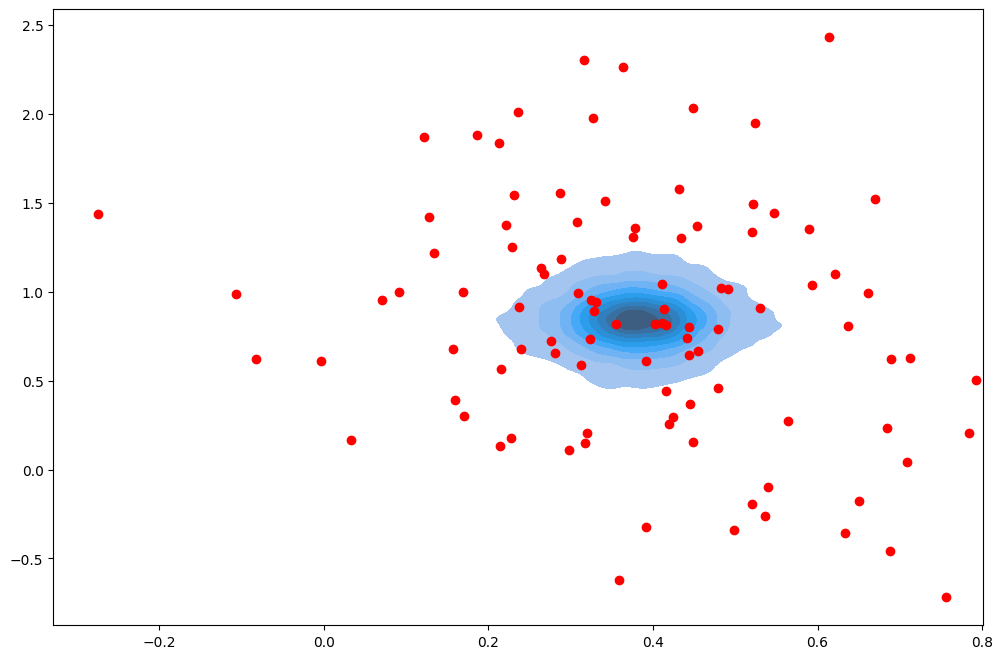

In [ ]:
posterior_predictiveGauss = np.zeros((popSizeGauss, sizeGauss[0], sizeGauss[1]))

samples_listGauss = historyGauss.get_population().get_accepted_sum_stats()
for i in range(len(samples_listGauss)):
    posterior_predictiveGauss[i, :, :] = samples_listGauss[i]["data"]

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    x=np.ravel(posterior_predictiveGauss[:, :, 0]),
    y=np.ravel(posterior_predictiveGauss[:, :, 1]),
    fill=True
)
plt.scatter(dataGauss["data"][:, 0], dataGauss["data"][:, 1], color='r')

With 100 2D data points, the volume of the space that is below the stopping distance shrinks exponentially, so we've had to increase the minimum_stopping_distance, leading to a pretty poor fit. Can we do better by using summary statistics?

In [ ]:
def sumStat(x):
    """
    Function to calculate appropriate summary statistics
    (mean and standard deviation) of the simulated data.

    Parameters
    ----------
    x : dict
        Dictionary containing:
            "data" : simulated multidimensional Gaussian
                    samples in the shape (number of data
                    points, number of dimensions)

    Returns
    -------
    np.array([float, float, float, float])
        Numpy array containing the means and standard
        deviations of the input data
    """
    data = x["data"]
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return np.hstack([means, stds])

def distanceSumStat(x, x0):
    """
    Function to calculate the distance between the
    summary statistics (mean and standard deviation)
    of the simulated data and ground truth.

    Parameters
    ----------
    x : dict
        Dictionary containing:
            "data" : simulated multidimensional Gaussian
                    samples in the shape (number of data
                    points, number of dimensions)
    x0 : dict
        Dictionary containing:
            "data" : ground truth multidimensional Gaussian
                    samples in the shape (number of data
                    points, number of dimensions)

    Returns
    -------
    float
        Distance between the summary statistics of the
        simulated and ground truth data.
    """
    return np.linalg.norm(sumStat(x) - sumStat(x0))

In [ ]:
abcGaussSumStat = pyabc.ABCSMC(modelWrapperGauss, priorGauss, distanceSumStat, population_size=500)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
INFO:ABC.Sampler:Parallelize sampling on 2 processes.


In [ ]:
db_pathGaussSumStat = os.path.join(tempfile.gettempdir(), "GaussSumStat.db")
abcGaussSumStat.new("sqlite:///" + db_pathGaussSumStat, dataGauss)

ABC.History INFO: Start <ABCSMC id=1, start_time=2026-01-06 13:22:34>
INFO:ABC.History:Start <ABCSMC id=1, start_time=2026-01-06 13:22:34>


In [ ]:
historyGaussSumStat = abcGaussSumStat.run(minimum_epsilon=0.1, max_nr_populations=50)

ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.71713290e+00.
INFO:ABC:t: 0, eps: 1.71713290e+00.
ABC INFO: Accepted: 500 / 1128 = 4.4326e-01, ESS: 5.0000e+02.
INFO:ABC:Accepted: 500 / 1128 = 4.4326e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 1.25801777e+00.
INFO:ABC:t: 1, eps: 1.25801777e+00.
ABC INFO: Accepted: 500 / 1028 = 4.8638e-01, ESS: 4.3619e+02.
INFO:ABC:Accepted: 500 / 1028 = 4.8638e-01, ESS: 4.3619e+02.
ABC INFO: t: 2, eps: 9.61583829e-01.
INFO:ABC:t: 2, eps: 9.61583829e-01.
ABC INFO: Accepted: 500 / 1093 = 4.5746e-01, ESS: 4.3970e+02.
INFO:ABC:Accepted: 500 / 1093 = 4.5746e-01, ESS: 4.3970e+02.
ABC INFO: t: 3, eps: 7.54843514e-01.
INFO:ABC:t: 3, eps: 7.54843514e-01.
ABC INFO: Accepted: 500 / 1057 = 4.7304e-01, ESS: 4.5339e+02.
INFO:ABC:Accepted: 500 / 1057 = 4.7304e-01, ESS: 4.5339e+02.
ABC INFO: t: 4, eps: 6.11829604e-01.
INFO:ABC:t: 4, eps: 6.11829604e-01.
ABC INFO: Accepted: 500 / 1105 = 4.5249e-01, ESS: 4.4432e+02.
INFO:ABC

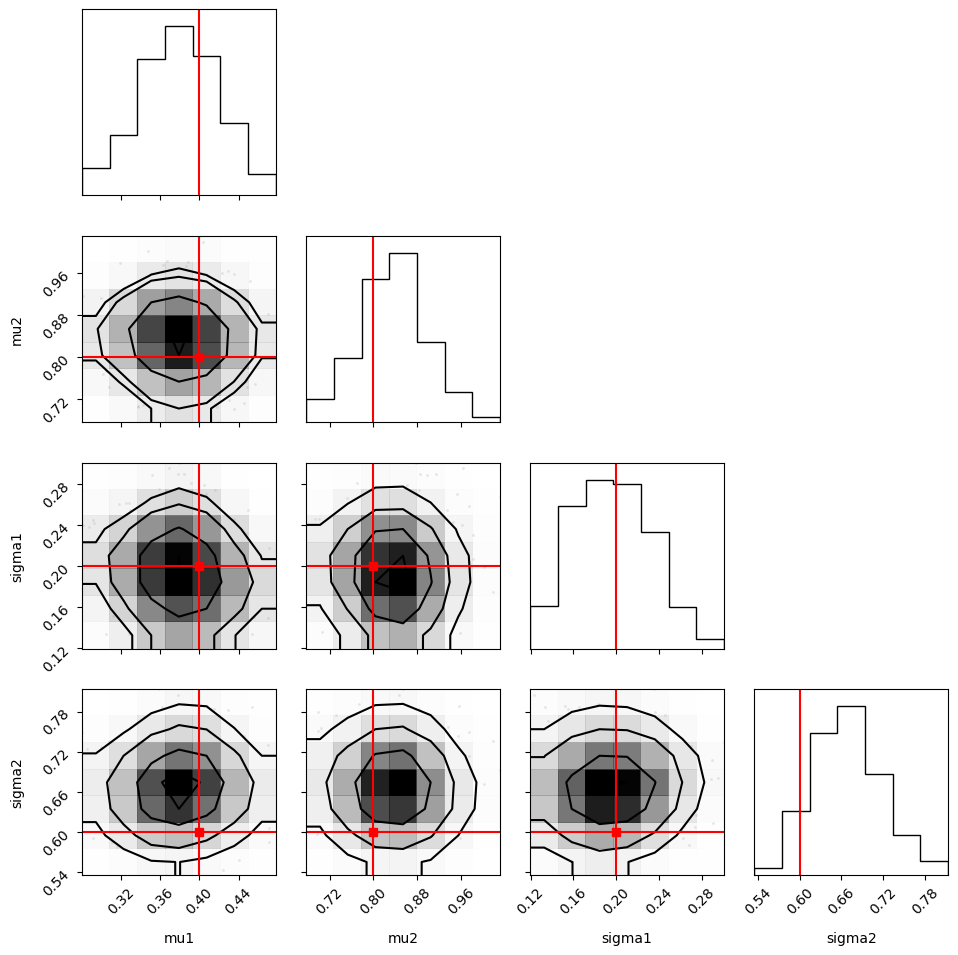

In [ ]:
posteriorGaussSumStat, wGaussSumStat = historyGaussSumStat.get_distribution(m=0)
# truth = [alphaTrue, betaTrue, gammaTrue]

ndimsGauss = np.shape(posteriorGaussSumStat)[1]

truthGauss = [paramsTrue[col] for col in posteriorGaussSumStat.columns]

# Make the base corner plot
figure = corner.corner(posteriorGaussSumStat.values, bins=7, smooth=1,
                       labels=posteriorGaussSumStat.columns)
# Extract the axes
axes = np.array(figure.axes).reshape((ndimsGauss, ndimsGauss))
# Loop over the diagonal
for i in range(ndimsGauss):
    ax = axes[i, i]
    ax.axvline(truthGauss[i], color="r")
# Loop over the histograms
for yi in range(ndimsGauss):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(truthGauss[xi], color="r")
        ax.axhline(truthGauss[yi], color="r")
        ax.plot(truthGauss[xi], truthGauss[yi], "sr")
plt.tight_layout()

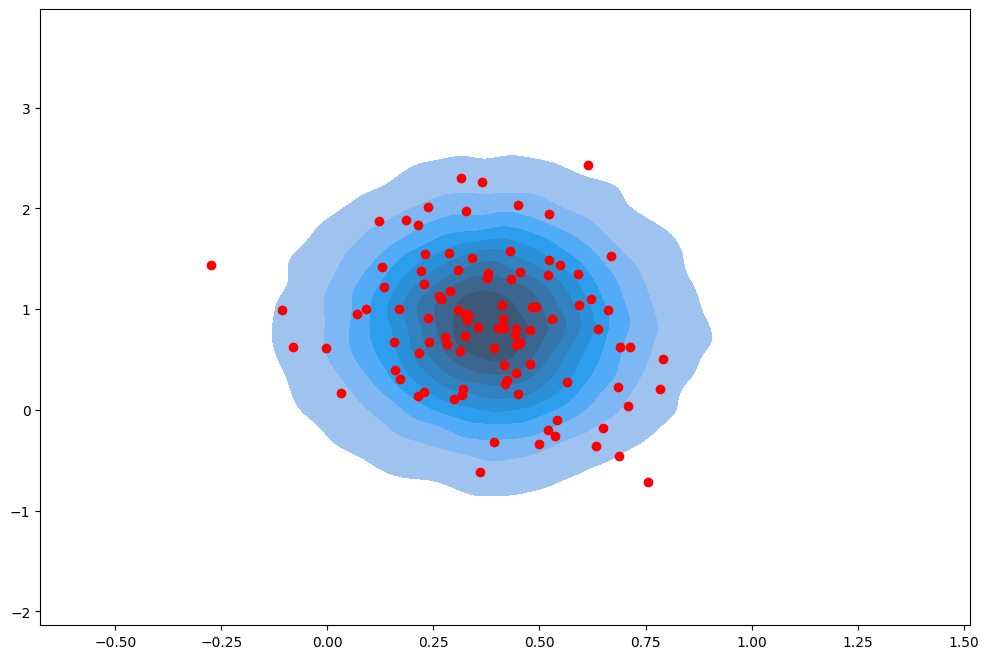

In [ ]:
posterior_predictiveGaussSumStat = np.zeros((popSizeGauss, sizeGauss[0], sizeGauss[1]))

samples_listGaussSumStat = historyGaussSumStat.get_population().get_accepted_sum_stats()
for i in range(len(samples_listGaussSumStat)):
    posterior_predictiveGaussSumStat[i, :, :] = samples_listGaussSumStat[i]["data"]

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    x=np.ravel(posterior_predictiveGaussSumStat[:, :, 0]),
    y=np.ravel(posterior_predictiveGaussSumStat[:, :, 1]),
    fill=True
)
plt.scatter(dataGauss["data"][:, 0], dataGauss["data"][:, 1], color='r')

So using appropriate summary statistics has allowed the inference to fit the data with far fewer samples than just trying to fit the raw data.

For a Gaussian distribution, the sufficient summary staistics that wholly represent the data are the mean and standard deviations, but in general there are a host of potential summary statistics that one could come up with, and many methods to adaptively scale the different statistics (https://doi.org/10.1214/16-BA1002) + weight more/less informative statistics (https://doi.org/10.1111/j.1467-9868.2011.01010.x). There are pre-built methods for these various semi-automatic summary statistic selection processes in  pyABC (https://pyabc.readthedocs.io/en/latest/examples.html#algorithms-and-features).

We switched to thinking about a 2D Gaussian to keep the summary statistics simple, but have a think about what sort of summary statistics would be appropriate for the Lotka Voltera system.